In [1]:
!pip install tensorflow-text==2.4.1
!pip install tensorflow==2.4.0
!pip install tensorflow-addons 
!pip install keras
!pip install pandas
!pip install scikit-learn
!pip install tf-models-official==2.4.0

     |████████████████████████████████| 3.4 MB 1.1 MB/s 
     |████████████████████████████████| 394.7 MB 13 kB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 1.1 MB 1.2 MB/s 
     |████████████████████████████████| 46 kB 2.5 MB/s 
     |████████████████████████████████| 99 kB 4.1 MB/s 
     |████████████████████████████████| 352 kB 5.9 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 211 kB 6.3 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22245 sha256=cdc8c8e12cee06e80a5d685c4daabe1625ad6e78618fb2987865522e1fffb748
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272445 sha256=e2b884

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import tensorflow_hub as tf_hub
import tensorflow_text as tf_text
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from official.nlp import optimization

In [3]:
np.random.seed(123)

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
df = pd.read_csv('../input/hotelreview/hotel-reviews.csv')

In [6]:
x = df['Description']

y = df[['Is_Response']]

In [7]:
y = OneHotEncoder(sparse=False).fit_transform(y)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.5)

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.values, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test.values, y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((x_val.values,y_val))

In [10]:
for feat, targ in train_ds.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

Features: b'We decided on this boutique hotel after reading reviews- PERFECT as far as location (- blocks to White House, etc.) and everything else that was important to us (service, cleanliness, not a chain) HIGHLY recommend...', Target: [1. 0.]
Features: b"I would just like to say that the Watertown in Seattle is a great find and can't wait to return \r\n-st: Breakfast is wonderful and complimentary not just the regular bagel and coffee they have eggs great selection of juices and bacon plus a lot more\r\n-nd The room big, clean, modern, with some nice views, plus some extra features like there cart services \r\n-rd The price and the customer service in my opinion cannot be beat the beautiful ladies there were fast, courteous, and seemed to really care that you are there try finding that a holiday inn or red roof inn\r\n-th the shuttle is a wonderful service free but you should tip the guy takes you write to the space nettle and a couple of blokes from pikes place what more do you wa

In [11]:
batch_size = 8
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)
model_selected = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4'
preprocessing_used = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [12]:
preprocessing = tf_hub.KerasLayer(preprocessing_used, name='bert_uncased_preprocessing')
text_test = ["The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok for a overnight stay if you're not too fussy. Would consider staying again if the price was right. Breakfast was free and just about better than nothing."]
text_preprocessed = preprocessing(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [[  101  1996  2282  2001  2785  1997  4550  2021  2018  1037  2200  2844
   5437  1997  6077  1012  3227  2917  2779  2021  7929  2005  1037 11585
   2994  2065  2017  1005  2128  2025  2205 28554  2100  1012  2052  5136
   6595  2153  2065  1996  3976  2001  2157  1012  6350  2001  2489  1998
   2074  2055  2488  2084  2498  1012   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 

In [13]:
def model_build():
    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
    preprocessing = tf_hub.KerasLayer(preprocessing_used, name='bert_uncased_preprocessing')
    BERT_input = preprocessing(input)
    BERT = tf_hub.KerasLayer(model_selected,trainable=True, name='BERT_Large')
    BERT_output = BERT(BERT_input)
    output = BERT_output['pooled_output']
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(2, activation='softmax', name='output_layer')(output)

    return tf.keras.Model(input,output)

In [14]:
model = model_build()

In [15]:
epochs = 8
steps = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps * epochs
warmup = int(0.1*num_train_steps)

starting_lr = 1e-6
optimizer_AdamW2= optimization.create_optimizer(init_lr=starting_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=warmup,
                                          optimizer_type='adamw')

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics='accuracy')

Hyperparameter: Batch Size(2,4), learning rate(1e-5,1e-4),preprocessing (cased)


control, Batch size 8, l_rate 1e-6, preprocessing uncased

In [17]:
logger = tf.keras.callbacks.CSVLogger(
    'training_log_BERT_uncased.csv', separator=',', append=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(    
    filepath='/savedmodel',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [18]:
model_train = model.fit(train_ds, validation_data = test_ds, epochs=epochs,callbacks = [logger,checkpoint])

Epoch 1/8
3894/3894 [==============================] - 1781s 450ms/step - loss: 0.5140 - accuracy: 0.7647 - val_loss: 0.2875 - val_accuracy: 0.8806
Epoch 2/8
3894/3894 [==============================] - 1755s 451ms/step - loss: 0.2956 - accuracy: 0.8812 - val_loss: 0.2750 - val_accuracy: 0.8875
Epoch 3/8
3894/3894 [==============================] - 1759s 452ms/step - loss: 0.2662 - accuracy: 0.8919 - val_loss: 0.2718 - val_accuracy: 0.8885
Epoch 4/8
3894/3894 [==============================] - 1761s 452ms/step - loss: 0.2481 - accuracy: 0.8987 - val_loss: 0.2713 - val_accuracy: 0.8908
Epoch 5/8
3894/3894 [==============================] - 1758s 451ms/step - loss: 0.2281 - accuracy: 0.9092 - val_loss: 0.2710 - val_accuracy: 0.8926
Epoch 6/8
3894/3894 [==============================] - 1760s 452ms/step - loss: 0.2092 - accuracy: 0.9166 - val_loss: 0.2844 - val_accuracy: 0.8924
Epoch 7/8
3894/3894 [==============================] - 1759s 452ms/step - loss: 0.1870 - accuracy: 0.9270 - val_

In [19]:
import matplotlib.pyplot as plt

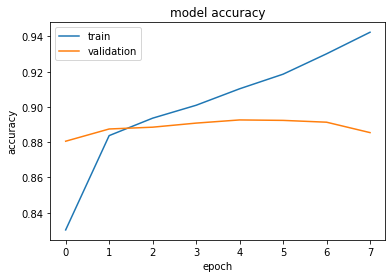

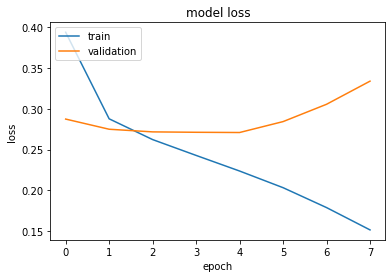

In [20]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")


def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")



plot_hist(model_train)
plt.savefig(f'Accuracy_uncased.png')
plt.show()

plot_hist_loss(model_train)
plt.savefig(f'Loss_uncased.png')
plt.show()

In [21]:
model.evaluate(validation_ds)

487/487 [==============================] - 72s 147ms/step - loss: 0.3152 - accuracy: 0.8852


[0.315192848443985, 0.885208010673523]

In [22]:
from sklearn.metrics import confusion_matrix
y_prediction = model.predict(validation_ds)

predicted_categories = tf.argmax(y_prediction, axis=1)


true_categories = tf.concat([y for x, y in validation_ds], axis=0)
true_categories = tf.argmax(true_categories, axis=1)

confusion = confusion_matrix(predicted_categories, true_categories)
print(true_categories)
print(predicted_categories)
print(confusion)
target_names = ['P','N']
print(classification_report(predicted_categories,true_categories, target_names=target_names))

from sklearn.metrics import ConfusionMatrixDisplay

conf_plot =ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=target_names)
conf_plot.plot()
plt.show()
plt.figure(figsize=(10, 10))
for images, labels in validation_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.title(class_names[predicted_categories[i]])
        plt.axis("off")

plt.show()

tf.Tensor([0 0 0 ... 0 0 0], shape=(3894,), dtype=int64)
tf.Tensor([0 0 0 ... 0 0 0], shape=(3894,), dtype=int64)
[[2477  232]
 [ 215  970]]


NameError: name 'classification_report' is not defined